# 回归

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/data/")
!pwd

/content/drive/My Drive/data


在回归问题中，我们的目标是预测连续值的输出，如价格或概率。将其与分类问题进行对比，其中我们的目标是从类列表中选择一个类（例如，图片包含苹果或橙色，识别图片中的哪个水果）。

这款笔记本采用了经典的Auto MPG数据集，并建立了一个模型来预测20世纪70年代末和80年代初汽车的燃油效率。为此，我们将为该模型提供该时段内许多汽车的描述。此描述包括以下属性：气缸，排量，马力和重量。

此示例使用tf.kerasAPI，有关详细信息，请参阅本指南。

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


Auto MPG数据集
该数据集可从UCI机器学习库获得。

获取数据
首先下载数据集。

In [4]:
dataset_path = keras.utils.get_file('auto-mpg.data','http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dataset_path

32768/30286 [================================] - 0s 3us/step


'/root/.keras/datasets/auto-mpg.data'

使用pandas导入它

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values="?", comment="\t",
                         sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


##清理数据
数据集包含一些未知值。

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

要保持这个初始教程，请简单地删除这些行。

In [0]:
dataset = dataset.dropna()

该"Origin"列真的是绝对的，而不是数字。所以把它转换为一热：

In [0]:
origin = dataset.pop('Origin')

In [10]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin ==2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 将数据拆分为火车并进行测试
现在将数据集拆分为训练集和测试集。

我们将在模型的最终评估中使用测试集。

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

## 检查数据
快速浏览训练集中几对列的联合分布。

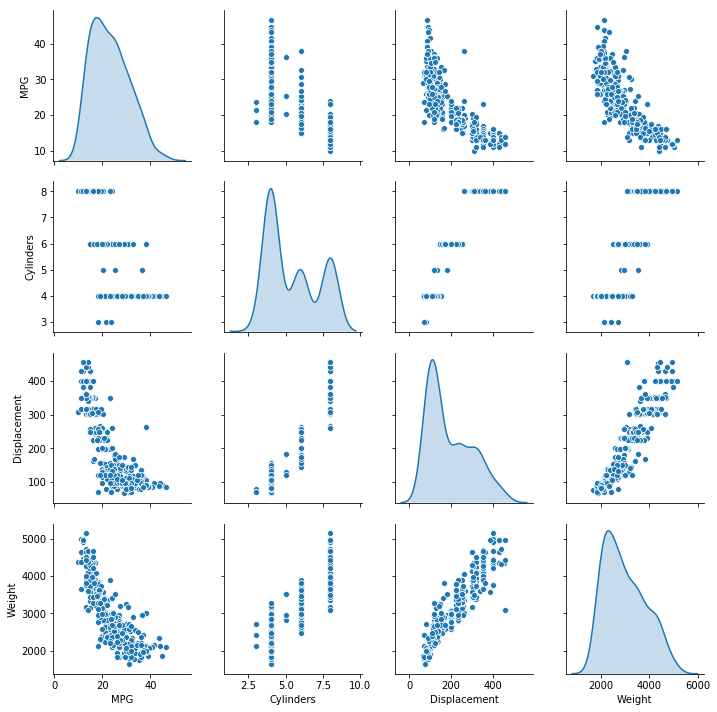

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')
plt.show()

另请查看整体统计数据：

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 从标签中分割功能
将目标值或“标签”与要素分开。此标签是您将训练模型进行预测的值。

In [0]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

##规范化数据
再看一下train_stats上面的块，注意每个特征的范围有多么不同。

优化使用不同比例和范围的特征进行标准化。虽然模型可能在没有特征归一化的情况下收敛，但它使训练更加困难，并且它使得结果模型依赖于输入中使用的单位的选择。

>注意：尽管我们仅从训练数据集中有意生成这些统计信息，但这些统计信息也将用于规范化测试数据集。我们需要这样做，将测试数据集投影到模型已经训练过的相同分布中。

In [0]:
def norm(x):
  return (x-train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

这个标准化数据是我们用来训练模型的数据。

>注意：用于标准化输入的统计数据（平均值和标准偏差）需要应用于馈送到模型的任何其他数据，以及我们之前执行的单热编码。这包括测试集以及模型在生产中使用时的实时数据。

## 该模型
###建立模型
让我们建立我们的模型。在这里，我们将使用Sequential具有两个密集连接的隐藏层的模型，以及返回单个连续值的输出层。模型构建步骤包含在一个函数中build_model，因为我们稍后将创建第二个模型。

In [0]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  model.compile(loss='mean_squared_error',
               optimizer=optimizer,
               metrics=['mean_absolute_error','mean_squared_error'])
  return model

In [0]:
model = build_model()

##检查模型
使用该.summary方法可以打印模型的简单描述

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


现在试试这个模型。10从培训数据中获取一批示例并进行调用model.predict。

In [22]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.4395745 ],
       [-0.20555091],
       [-0.59149766],
       [-0.37557632],
       [-0.10695127],
       [-0.09151937],
       [-0.11353027],
       [-0.3041358 ],
       [-0.19154394],
       [-0.35131416]], dtype=float32)

它似乎工作，它产生预期的形状和类型的结果。

##训练模型
训练模型1000个时期，并记录对象的训练和验证准确性history。

In [25]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 ==0: print('')
    print('.', end='')
    
EPOCHS= 1000

history = model.fit(normed_train_data,
                   train_labels,
                   epochs=EPOCHS,
                   validation_split=0.2,
                   verbose=0,
                   callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

使用存储在history对象中的统计数据可视化模型的训练进度。


In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.518815,1.013830,2.518815,8.821292,2.306089,8.821293,995
996,2.482013,0.957781,2.482013,9.664194,2.356653,9.664194,996
997,2.524943,1.032607,2.524943,9.203015,2.338159,9.203014,997
998,2.539688,1.005691,2.539688,8.773190,2.306954,8.773190,998
999,2.495428,0.969324,2.495428,9.119974,2.342116,9.119975,999


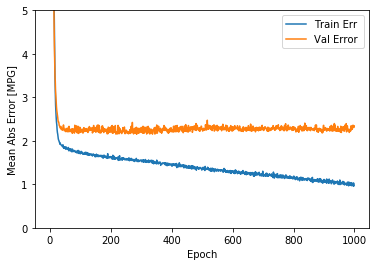

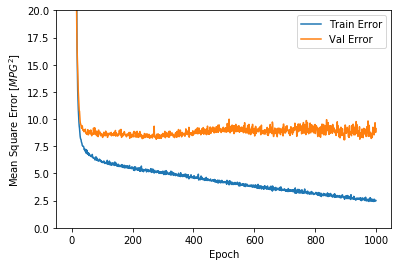

In [31]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'],hist['mean_absolute_error'],
          label='Train Err ')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
          label='Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'],hist['mean_squared_error'],
          label='Train Error')
  plt.plot(hist['epoch'],hist['val_mean_squared_error'],
          label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()
  
  
plot_history(history)

该图表显示在约100个时期之后几乎没有改进，或甚至在验证错误中降级。model.fit当验证分数没有改善时，让我们更新呼叫以自动停止训练。我们将使用EarlyStopping回调来测试每个时期的训练条件。如果经过一定数量的时期而没有显示出改进，则自动停止训练。

您可以在此处了解有关此回调的更多信息。


...............................................

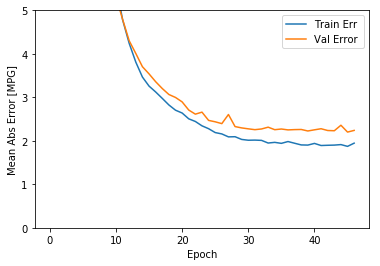

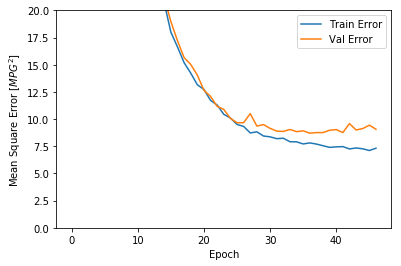

In [32]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

该图表显示在验证集上，平均误差通常约为+/- 2 MPG。这个好吗？我们会把这个决定留给你。

让我们看一下使用测试集来概括模型，我们在训练模型时没有使用。这告诉我们，当我们在现实世界中使用模型时，我们可以期待模型预测。

In [33]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.90 MPG


## 作出预测
最后，使用测试集中的数据预测MPG值：

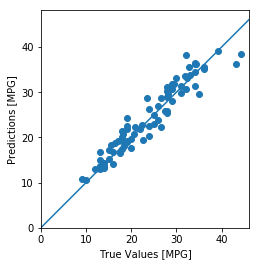

In [36]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100,100], [-100, 100])

看起来我们的模型预测得相当好。我们来看看错误分布。

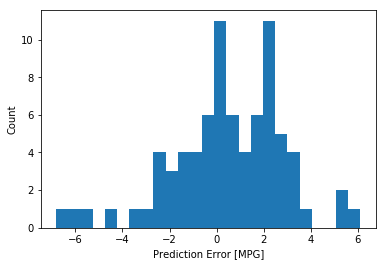

In [37]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

它不是很高斯，但我们可能会期望，因为样本数量非常少。

## 结论
这款笔记本介绍了一些处理回归问题的技巧。

- 均方误差（MSE）是用于回归问题的常见损失函数（不同的损失函数用于分类问题）。
- 同样，用于回归的评估指标与分类不同。常见的回归度量是平均绝对误差（MAE）。
- 当数字输入数据要素具有不同范围的值时，应将每个要素独立地缩放到相同范围。
- 如果没有太多的训练数据，一种技术是偏好一个隐藏层很少的小网络，以避免过度拟合。
- 早期停止是防止过度拟合的有用技术。